In [232]:
import pandas as pd
import numpy as np



In [233]:
df=pd.read_csv('/content/data.csv',usecols=["SalePrice", "MSSubClass", "MSZoning", "LotFrontage", "LotArea",
                                         "Street", "YearBuilt", "LotShape", "1stFlrSF", "2ndFlrSF"]).dropna()

In [234]:
for i in df.columns:
    print("Column name {} and unique values are {}".format(i,len(df[i].unique())))

Column name MSSubClass and unique values are 15
Column name MSZoning and unique values are 5
Column name LotFrontage and unique values are 110
Column name LotArea and unique values are 869
Column name Street and unique values are 2
Column name LotShape and unique values are 4
Column name YearBuilt and unique values are 112
Column name 1stFlrSF and unique values are 678
Column name 2ndFlrSF and unique values are 368
Column name SalePrice and unique values are 597


In [235]:
import datetime
datetime.datetime.now().year

2022

In [236]:
df['Total Years']=datetime.datetime.now().year-df['YearBuilt']

In [237]:
df.drop("YearBuilt",axis=1,inplace=True)

In [238]:
df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', '1stFlrSF', '2ndFlrSF', 'SalePrice', 'Total Years'],
      dtype='object')

In [239]:
cat_features=["MSSubClass", "MSZoning", "Street", "LotShape"]
out_feature="SalePrice"

In [241]:
from sklearn.preprocessing import LabelEncoder
lbl_encoders={}
for feature in cat_features:
    lbl_encoders[feature]=LabelEncoder()
    df[feature]=lbl_encoders[feature].fit_transform(df[feature])
df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,1stFlrSF,2ndFlrSF,SalePrice,Total Years
0,5,3,65.0,8450,1,3,856,854,208500,19
1,0,3,80.0,9600,1,3,1262,0,181500,46
2,5,3,68.0,11250,1,0,920,866,223500,21
3,6,3,60.0,9550,1,0,961,756,140000,107
4,5,3,84.0,14260,1,0,1145,1053,250000,22
...,...,...,...,...,...,...,...,...,...,...
1455,5,3,62.0,7917,1,3,953,694,175000,23
1456,0,3,85.0,13175,1,3,2073,0,210000,44
1457,6,3,66.0,9042,1,3,1188,1152,266500,81
1458,0,3,68.0,9717,1,3,1078,0,142125,72


In [243]:
cat_features=np.stack([df['MSSubClass'],df['MSZoning'],df['Street'],df['LotShape']],1)
cat_features

array([[5, 3, 1, 3],
       [0, 3, 1, 3],
       [5, 3, 1, 0],
       ...,
       [6, 3, 1, 3],
       [0, 3, 1, 3],
       [0, 3, 1, 3]])

In [244]:
import torch
cat_features=torch.tensor(cat_features,dtype=torch.int64)
cat_features

tensor([[5, 3, 1, 3],
        [0, 3, 1, 3],
        [5, 3, 1, 0],
        ...,
        [6, 3, 1, 3],
        [0, 3, 1, 3],
        [0, 3, 1, 3]])

In [181]:
cont_features=[]
for i in df.columns:
    if i in ["MSSubClass", "MSZoning", "Street", "LotShape","SalePrice"]:
        pass
    else:
        cont_features.append(i)


In [182]:
cont_values=np.stack([df[i].values for i in cont_features],axis=1)
cont_values=torch.tensor(cont_values,dtype=torch.float)
cont_values

tensor([[   65.,  8450.,  2003.,   856.,   854.,    19.],
        [   80.,  9600.,  1976.,  1262.,     0.,    46.],
        [   68., 11250.,  2001.,   920.,   866.,    21.],
        ...,
        [   66.,  9042.,  1941.,  1188.,  1152.,    81.],
        [   68.,  9717.,  1950.,  1078.,     0.,    72.],
        [   75.,  9937.,  1965.,  1256.,     0.,    57.]])

In [183]:
cont_values.dtype

torch.float32

In [184]:
y=torch.tensor(df['SalePrice'].values,dtype=torch.float).reshape(-1,1)
y

tensor([[208500.],
        [181500.],
        [223500.],
        ...,
        [266500.],
        [142125.],
        [147500.]])

In [185]:
cat_features.shape,cont_values.shape,y.shape

((1201, 4), torch.Size([1201, 6]), torch.Size([1201, 1]))

In [186]:
cat_dims=[len(df[col].unique()) for col in ["MSSubClass", "MSZoning", "Street", "LotShape"]]

In [187]:
embedding_dim= [(x, min(50, (x + 1) // 2)) for x in cat_dims]

In [197]:
cat_featuresz=cat_features[:4]
cat_featuresz

tensor([[5, 3, 1, 3],
        [0, 3, 1, 3],
        [5, 3, 1, 0],
        [6, 3, 1, 0]])

In [245]:
import torch
import torch.nn as nn
import torch.nn.functional as F
embed_representation=nn.ModuleList([nn.Embedding(inp,out) for inp,out in embedding_dim])
embed_representation

ModuleList(
  (0): Embedding(15, 8)
  (1): Embedding(5, 3)
  (2): Embedding(2, 1)
  (3): Embedding(4, 2)
)

In [246]:
pd.set_option('display.max_rows', 500)
embedding_val=[]
for i,e in enumerate(embed_representation):
    embedding_val.append(e(cat_features[:,i]))

In [247]:
z = torch.cat(embedding_val, 1)
z

tensor([[ 1.4019,  0.1468,  0.0074,  ..., -1.3134, -0.5665,  1.4779],
        [ 0.5217,  0.1090,  0.3477,  ..., -1.3134, -0.5665,  1.4779],
        [ 1.4019,  0.1468,  0.0074,  ..., -1.3134,  0.0164,  0.5916],
        ...,
        [-0.1256,  0.5867, -0.6605,  ..., -1.3134, -0.5665,  1.4779],
        [ 0.5217,  0.1090,  0.3477,  ..., -1.3134, -0.5665,  1.4779],
        [ 0.5217,  0.1090,  0.3477,  ..., -1.3134, -0.5665,  1.4779]],
       grad_fn=<CatBackward0>)

In [248]:
droput=nn.Dropout(.4)


In [249]:
final_embed=droput(z)
final_embed


tensor([[ 2.3365,  0.2447,  0.0124,  ..., -2.1890, -0.0000,  2.4632],
        [ 0.0000,  0.1816,  0.0000,  ..., -2.1890, -0.9441,  2.4632],
        [ 0.0000,  0.2447,  0.0124,  ..., -0.0000,  0.0274,  0.0000],
        ...,
        [-0.2094,  0.9778, -0.0000,  ..., -2.1890, -0.0000,  2.4632],
        [ 0.8695,  0.1816,  0.0000,  ..., -0.0000, -0.0000,  2.4632],
        [ 0.8695,  0.0000,  0.0000,  ..., -0.0000, -0.0000,  2.4632]],
       grad_fn=<MulBackward0>)

In [250]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class FeedForwardNN(nn.Module):

    def __init__(self, embedding_dim, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(inp,out) for inp,out in embedding_dim])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((out for inp,out in embedding_dim))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [251]:
torch.manual_seed(100)
model=FeedForwardNN(embedding_dim,len(cont_features),1,[100,50],p=0.4)

In [252]:
loss_function=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.01)

In [201]:
batch_size=1200
test_size=int(batch_size*0.15)
train_categorical=cat_features[:batch_size-test_size]
test_categorical=cat_features[batch_size-test_size:batch_size]
train_cont=cont_values[:batch_size-test_size]
test_cont=cont_values[batch_size-test_size:batch_size]
y_train=y[:batch_size-test_size]
y_test=y[batch_size-test_size:batch_size]

In [202]:
len(train_categorical),len(test_categorical),len(train_cont),len(test_cont),len(y_train),len(y_test)

(1020, 180, 1020, 180, 1020, 180)

In [253]:
epochs=5000
final_losses=[]
for i in range(epochs):
    i=i+1
    y_pred=model(train_categorical,train_cont)
    loss=torch.sqrt(loss_function(y_pred,y_train)) ### RMSE
    final_losses.append(loss.item())
    if i%10==1:
        print("Epoch number: {} and the loss : {}".format(i,loss.item()))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch number: 1 and the loss : 200496.84375
Epoch number: 11 and the loss : 200493.9375
Epoch number: 21 and the loss : 200489.4375
Epoch number: 31 and the loss : 200482.625
Epoch number: 41 and the loss : 200474.484375
Epoch number: 51 and the loss : 200462.25
Epoch number: 61 and the loss : 200447.671875
Epoch number: 71 and the loss : 200430.125
Epoch number: 81 and the loss : 200408.875
Epoch number: 91 and the loss : 200383.5625
Epoch number: 101 and the loss : 200356.796875
Epoch number: 111 and the loss : 200324.53125
Epoch number: 121 and the loss : 200288.25
Epoch number: 131 and the loss : 200252.984375
Epoch number: 141 and the loss : 200207.765625
Epoch number: 151 and the loss : 200159.484375
Epoch number: 161 and the loss : 200113.59375
Epoch number: 171 and the loss : 200065.578125
Epoch number: 181 and the loss : 200001.046875
Epoch number: 191 and the loss : 199947.984375
Epoch number: 201 and the loss : 199876.125
Epoch number: 211 and the loss : 199814.625
Epoch num

[200496.84375,
 200496.5,
 200496.25,
 200495.953125,
 200495.734375,
 200495.390625,
 200495.09375,
 200494.796875,
 200494.5,
 200494.15625,
 200493.9375,
 200493.5,
 200493.140625,
 200492.734375,
 200492.28125,
 200491.765625,
 200491.453125,
 200491.015625,
 200490.421875,
 200490.03125,
 200489.4375,
 200488.96875,
 200488.53125,
 200488.046875,
 200487.171875,
 200486.5625,
 200486.0625,
 200485.40625,
 200484.578125,
 200483.828125,
 200482.625,
 200482.203125,
 200481.234375,
 200480.375,
 200479.59375,
 200479.359375,
 200477.796875,
 200476.65625,
 200476.109375,
 200474.96875,
 200474.484375,
 200472.578125,
 200472.0,
 200470.421875,
 200469.625,
 200468.234375,
 200467.328125,
 200465.703125,
 200465.515625,
 200462.5,
 200462.25,
 200460.703125,
 200459.78125,
 200458.453125,
 200457.25,
 200454.90625,
 200453.875,
 200452.734375,
 200450.390625,
 200449.703125,
 200447.671875,
 200446.4375,
 200444.484375,
 200443.34375,
 200439.875,
 200439.546875,
 200438.0,
 200436.3

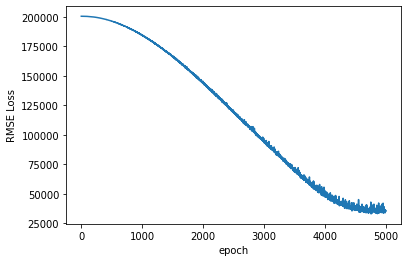

In [254]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(epochs),final_losses)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch');

In [222]:
li

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
